### Clustering and Regeression model

We will use this notebook to derive weights from regression model to make light weight visualization and cluster counties.


In [1]:
# Set parameters 
BUCKET = 'opioid-care'
PROJECT = 'opioid-care'
REGION = 'us-central1'

import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [2]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [3]:
# Let's import libraries
import pandas as pd
pd.options.display.float_format='{:,.2f}'.format

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from google.datalab import bigquery as bq

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer, StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from itertools import combinations

### Let's ingest data

In [4]:
# this is final dataset to split into eval and train dataset
query = 'select * from hackathon_opioid.best_features'
best_features = bq.Query(query).execute().result().to_dataframe()
best_features.shape
best_features.head(2)

(3141, 103)

,health_factors_pctile_within_state,length_of_life_pctile_within_state,pct_smokers,pct_physically_inactive,pct_excessive_drinking,preventable_hospitalization_rate,pct_some_college,pct_frequent_mental_distress,pct_diabetic,median_household_income,...,tedsd_psyprob_1,retaildrug_amobarbital__schedule_2_,retaildrug_amphetamine,retaildrug_fentanyl_base,retaildrug_lisdexamfetamine,retaildrug_methylphenidate__dl_d_l_isomers_,retaildrug_tapentadol,drug_overdose_mortality_rate,state,county
0,98.00,93.00,17.50,27.60,18.30,52.58,54.05,11.50,10.60,"43,205.00",...,0.29,48.77,"419,978.29","7,356.33","127,363.50","443,237.97","78,105.00",22.00,WA,Grays Harbor
1,75.00,83.00,17.00,22.00,19.40,38.08,57.86,11.30,10.20,"44,235.00",...,0.29,48.77,"419,978.29","7,356.33","127,363.50","443,237.97","78,105.00",23.20,WA,Cowlitz


In [5]:
query = 'select * from hackathon_opioid.master_data'
master_df = bq.Query(query).execute().result().to_dataframe()
master_df.shape
master_df.head()

(3141, 25)

,state,state_name,county,mentally_unhealthy_days,physically_unhealthy_days,pct_frequent_mental_distress,pct_excessive_drinking,injury_death_rate,age_adjusted_mortality,pct_frequent_physical_distress,...,pct_unemployed,length_of_life_pctile_within_state,median_household_income,pct_physically_inactive,length_of_life_quartile_within_state,pct_children_in_poverty,income_20th_percentile,pct_children_eligible_free_lunch,pct_diabetic,drug_overdose_mortality_rate
0,AK,Alaska,Skagway-Hoonah-Angoon,3.17,3.63,10.07,20.53,103.15,314.50,10.97,...,11.78,5.00,"57,495.98",20.00,1.00,24.50,"26,594.53",35.36,10.67,17.58
1,AK,Alaska,Wrangell-Petersburg,2.99,3.33,9.30,20.63,71.13,328.20,9.80,...,9.37,9.00,"54,748.91",20.80,1.00,13.11,"24,149.91",41.26,9.33,17.58
2,AL,Alabama,Macon,5.20,5.60,16.90,10.10,83.62,530.50,18.10,...,9.13,77.00,"28,518.00",31.10,4.00,44.40,"11,981.00",87.61,16.85,14.44
3,AL,Alabama,Pickens,5.00,5.10,15.90,11.40,94.15,515.50,16.40,...,8.22,56.00,"31,933.00",33.60,3.00,34.50,"11,224.00",55.06,15.50,14.44
4,AL,Alabama,Conecuh,5.30,5.80,17.10,10.30,97.75,542.60,18.45,...,10.74,81.00,"29,101.00",33.50,4.00,41.20,"10,693.00",82.91,16.85,14.44


In [6]:
def drop_duplicate_columns(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

df = pd.merge(master_df, best_features,  how='inner', on=['state','county'], suffixes=('', '_y'))
drop_duplicate_columns(df)

df.shape
df.head()

(3141, 116)

,state,state_name,county,mentally_unhealthy_days,physically_unhealthy_days,pct_frequent_mental_distress,pct_excessive_drinking,injury_death_rate,age_adjusted_mortality,pct_frequent_physical_distress,...,tedsd_sub2_7,tedsd_sub3_7,tedsd_dsmcrit_14,tedsd_psyprob_1,retaildrug_amobarbital__schedule_2_,retaildrug_amphetamine,retaildrug_fentanyl_base,retaildrug_lisdexamfetamine,retaildrug_methylphenidate__dl_d_l_isomers_,retaildrug_tapentadol
0,AK,Alaska,Skagway-Hoonah-Angoon,3.17,3.63,10.07,20.53,103.15,314.50,10.97,...,0.03,0.02,0.02,0.39,10.15,"31,327.52","1,059.96","9,784.34","32,818.62","7,749.50"
1,AK,Alaska,Wrangell-Petersburg,2.99,3.33,9.30,20.63,71.13,328.20,9.80,...,0.03,0.02,0.02,0.39,10.15,"31,327.52","1,059.96","9,784.34","32,818.62","7,749.50"
2,AL,Alabama,Macon,5.20,5.60,16.90,10.10,83.62,530.50,18.10,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"
3,AL,Alabama,Pickens,5.00,5.10,15.90,11.40,94.15,515.50,16.40,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"
4,AL,Alabama,Conecuh,5.30,5.80,17.10,10.30,97.75,542.60,18.45,...,0.06,0.03,0.00,0.05,5.47,"507,395.33","7,558.55","285,042.66","290,860.23","262,860.00"


In [7]:
# Based on our EDA and multiple test we figured out below features are good representation of our data...

target = ['drug_overdose_mortality_rate']
categorical_cols = ['state']
numerical_cols = ['mentally_unhealthy_days',
 'physically_unhealthy_days',
 'pct_frequent_mental_distress',
 'pct_excessive_drinking',
 'injury_death_rate',
 'age_adjusted_mortality',
 'pct_frequent_physical_distress',
 'pct_smokers',
 'pct_insufficient_sleep',
 'preventable_hospitalization_rate',
 'pct_some_college',
 'pct_fair_or_poor_health',
 'pct_unemployed',
 'length_of_life_pctile_within_state',
 'median_household_income',
 'pct_physically_inactive',
 'length_of_life_quartile_within_state',
 'pct_children_in_poverty',
 'income_20th_percentile',
 'pct_children_eligible_free_lunch',
 'pct_diabetic']

In [8]:
features_df = df[categorical_cols + numerical_cols + target]

In [9]:
label_df = features_df[target]
del features_df['drug_overdose_mortality_rate']

input_values = features_df[numerical_cols].values
labels = label_df.values

In [10]:
# Split training data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(input_values, labels, random_state=0)

In [11]:
def preprocessing(data, strategy='mean', scaling='std'):
    data = Imputer(strategy=strategy).fit_transform(data)
    if scaling=='std':
        data = StandardScaler().fit_transform(data)
    return data
  
prep_train = preprocessing(X_train)
prep_val = preprocessing(X_val)

array([0.60192218, 0.10407381])

Text(0.5,1,'Counties Clusters')

Text(0.5,0,'PCA 1')

Text(0.5,0,'PCA 2')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


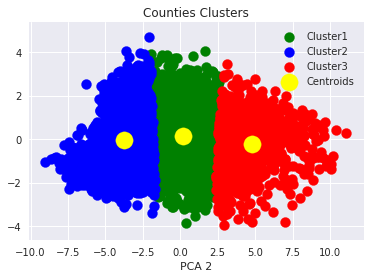

In [12]:
# Let's decompose data for visualization

pca = PCA(n_components=2)
pca_train = pca.fit_transform(np.vstack((prep_train, prep_val)))
explained_variance = pca.explained_variance_ratio_
explained_variance

pca_kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
y_pca_kmeans = pca_kmeans.fit_predict(pca_train)


plt.scatter(pca_train[y_pca_kmeans==0,0], pca_train[y_pca_kmeans == 0, 1], s=100, c='green', label='Cluster1')
plt.scatter(pca_train[y_pca_kmeans==1,0], pca_train[y_pca_kmeans == 1, 1], s=100, c='blue', label='Cluster2')
plt.scatter(pca_train[y_pca_kmeans==2,0], pca_train[y_pca_kmeans == 2, 1], s=100, c='red', label='Cluster3')
plt.scatter(pca_kmeans.cluster_centers_[:,0], pca_kmeans.cluster_centers_[:,1], s=300, c='yellow', label = 'Centroids')
plt.title('Counties Clusters')
plt.xlabel('PCA 1')
plt.xlabel('PCA 2')
plt.legend()
plt.show()

In [13]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10, random_state=0)
clust_labels = model.fit_predict(np.vstack((prep_train, prep_val)))
      
data = pd.DataFrame(clust_labels)
col_name = 'KMeans_label'
if col_name in df.columns:
  del df[col_name]
df.insert(loc=df.shape[1], column=col_name, value=data)

### Check accuracy for KMeans label

In [24]:

#Check if our clustering labels marked high risk counties correctly
high_risk_labeled_counties = df[df['KMeans_label']==2]

high_death_rate_counties_index = df.drug_overdose_mortality_rate.sort_values(ascending=False)[:len(high_risk_labeled_counties)].index
high_death_rate_counties = list(df[['state_name','county']].iloc[high_death_rate_counties_index, :]['county'])

top20_risk_counties_index = df.drug_overdose_mortality_rate.sort_values(ascending=False)[:20].index
top20_risk_counties =  list(df[['state_name','county']].iloc[top20_risk_counties_index, :]['county'])
non_matched_counties = []
for county in list(top20_risk_counties):
  if county not in list(high_risk_labeled_counties.county):
    non_matched_counties.append(county)
print("Non matched counties in top 20 high risk counties: ", non_matched_counties, "\n")

matched_counties = []
for county in list(high_death_rate_counties):
  if county in list(high_risk_labeled_counties.county):
    matched_counties.append(county)
    
print("Total counties: ", df.county.nunique())
print("Distinct counties labeled as high risk by Model: ", high_risk_labeled_counties.county.nunique(), "\n")
print("Matched counties: {} out of {} high risk counties".format(len(matched_counties), 1000))
print("Accuracy: ", len(matched_counties)/1000)


Non matched counties in top 20 high risk counties:  ['Tishomingo', 'Johnston', 'Berkeley', 'Cabell', 'McDowell'] 

Total counties:  1848
Distinct counties labeled as high risk by Model:  893 

Matched counties: 835 out of 1000 high risk counties
Accuracy:  0.835


## Regression model

In [16]:
# Build regression model to derive weights for regression models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sk_lin_reg_model = LinearRegression().fit(prep_train, y_train)
predict_val = sk_lin_reg_model.predict(prep_val)
loss = 0.5 * np.sqrt(mean_squared_error(predict_val, y_val))
#loss = mean_squared_error(predict_val, y_val)
loss

2.229751568728799

In [17]:
"Intercept: ", sk_lin_reg_model.intercept_
"Coefficients/Weights: ", sk_lin_reg_model.coef_

('Intercept: ', array([15.50524253]))

('Coefficients/Weights: ',
 array([[ 5.31878201,  3.00168225, -4.9015997 , -1.75958047,  1.94316963,
         -0.24863079, -0.72964125,  0.64536857,  0.7555193 ,  0.40105322,
         -0.32502674, -1.35972713,  0.47907198,  1.54595461,  0.59505765,
         -0.61294012, -0.83132119, -0.85998715,  0.2737373 ,  0.42533616,
         -1.20849431]]))

In [18]:
coefficient_df = pd.DataFrame(dict(zip(numerical_cols, sk_lin_reg_model.coef_.reshape(-1,1))))
coefficient_df['intecept'] = np.array([15.26071996])
coefficient_df.head(5)

,age_adjusted_mortality,income_20th_percentile,injury_death_rate,length_of_life_pctile_within_state,length_of_life_quartile_within_state,median_household_income,mentally_unhealthy_days,pct_children_eligible_free_lunch,pct_children_in_poverty,pct_diabetic,...,pct_frequent_mental_distress,pct_frequent_physical_distress,pct_insufficient_sleep,pct_physically_inactive,pct_smokers,pct_some_college,pct_unemployed,physically_unhealthy_days,preventable_hospitalization_rate,intecept
0,-0.25,0.27,1.94,1.55,-0.83,0.60,5.32,0.43,-0.86,-1.21,...,-4.90,-0.73,0.76,-0.61,0.65,-0.33,0.48,3.00,0.40,15.26


### Clustering model with sklearn modules

In [19]:
# Clustering with scikit learn
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
seed = 0
models = []
nclust=3
models.append(('Gaussian_Mixture', GaussianMixture(n_components=nclust,init_params='kmeans', max_iter=100, random_state=seed)))
models.append(('Affinity_Propagation', AffinityPropagation(damping = 0.5, max_iter = 100, affinity = 'euclidean')))
models.append(('Agglomerative_Clustering', AgglomerativeClustering(n_clusters=nclust, affinity = 'euclidean', linkage = 'ward')))
models.append(('KMeans', KMeans(n_clusters=nclust, init='k-means++', max_iter=100, n_init=10, random_state=seed)))
  
def sk_cluster(data, models):
  for name, model in models:
    if name == 'Gaussian_Mixture':
      model.fit(data)
      cent = 0
      clust_labels = model.predict(data)

    elif name == 'Agglomerative_Clustering':
      clust_labels = model.fit_predict(data)
      cent = 0

    else:
      model.fit(data)
      clust_labels = model.predict(data)
      cent = model.cluster_centers_
      
    data_df = pd.DataFrame(clust_labels)
    col_name = str(name)+'_label'
    if col_name in df.columns:
      del df[col_name]
    df.insert(loc=df.shape[1], column=col_name, value=data_df)
  
  return (clust_labels, cent) # It will return only KMeans centroids and cluster label for visualization in datalab

clusters_df = sk_cluster(np.vstack((prep_train,prep_val)), models) # Cluster centers are available for KMeans and Affinity Prog

In [20]:
labels_df = df[['state','state_name','county','Gaussian_Mixture_label','Affinity_Propagation_label',
                                           'Agglomerative_Clustering_label','KMeans_label']]

labels_df.to_csv('eda_output/counties_cluster.csv', index = False)

!gsutil cp 'eda_output/counties_cluster.csv' 'gs://opioid-care/eda_output/counties_cluster.csv'

Copying file://eda_output/counties_cluster.csv [Content-Type=text/csv]...
/ [1 files][ 89.9 KiB/ 89.9 KiB]                                                
Operation completed over 1 objects/89.9 KiB.                                     


In [21]:
# Write data to Bigquery
import google.datalab.bigquery as bq

project = 'opioid-care'
bq_dataset = 'hackathon_opioid'
bq_table = 'counties_cluster'

def write_to_bigquery(df, project, bq_dataset, bq_table):
    # Define BigQuery dataset and table
    dataset = bq.Dataset(bq_dataset)
    table = bq.Table(bq_dataset + '.' + bq_table)

    # Create BigQuery dataset
    if not dataset.exists():
        dataset.create()

    # Create or overwrite the existing table if it exists
    table_schema = bq.Schema.from_data(df)
    table.create(schema = table_schema, overwrite = True)

    # Write the DataFrame to a BigQuery table
    try:
        table.insert(df)
        print("Table successfully written to BigQuery")
    except IOError as e:
        print(e, "Write operation failed")

In [22]:
# Write features to bigquery table
write_to_bigquery(labels_df, project, bq_dataset, bq_table)

Table successfully written to BigQuery


In [23]:
write_to_bigquery(coefficient_df, project, bq_dataset, 'regression_coefficient')

Table successfully written to BigQuery
